In [3]:
import KeithleyGUI.keithley as keithley
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pymeasure.instruments.resources import list_resources
import time
%matplotlib inline
try : 
    a = list(list_resources())
except Exception as E:
    print(E)
    pass
K = keithley.Keithley6517B()

0 : ASRL3::INSTR : Not known
1 : GPIB0::27::INSTR : KEITHLEY INSTRUMENTS INC.,MODEL 6517B,1355622,A12/700x 


In [4]:
def measure_IV(device, vmin = 0.5 + 0.5e-3, vmax = 0.5 + 1.0e-3, npoints = 10):
    for v_val in np.linspace(vmin, vmax, npoints):
        device.set_voltage(v_val)
        yield (v_val, device.read_current(autorange=False))
    device.set_voltage(0)
    # device.close()

In [4]:
def find_range(current):
    ranges = 2 * 10.0**np.arange(-12.0, -4.0, 1.0)
    idx = np.where(ranges > current)[0]
    if len(idx) > 0:
        return ranges[min(idx)]
    return None

In [93]:
find_range(0.0000000012) 

np.float64(2e-09)

In [100]:
# K.set_voltage_range(2)
# K.device.write(":SENS:FUNC 'CURR';")
# K.device.write(":SENS:CURR:RANG:AUTO OFF;:SENS:CURR:RANG 2e-10")
K.device.write(":SENS:CURR:NPLC 10")

20

In [146]:
K.device.write(":SENS:CURR:RANG?;")
K.device.read()

VisaIOError: VI_ERROR_INV_OBJECT (-1073807346): The given session or object reference is invalid.

In [32]:
K.device.write(":SENS:CURR:RANG:AUTO ON;")

26

In [38]:
K.device.write(":SENS:CURR:RANG:AUTO ON;:SENS:CURR:RANG 2e-9")

46

In [33]:
K.device.write(":READ?;")
K.device.read()

'-00.02787E-09NADC,07:39:08.00,15-Oct-2024,+02870RDNG#\n'

In [4]:
K.device.read()

'2.0000000E-02\n'

In [137]:
K.set_voltage(-0.12)

In [69]:
K.set_current_range(2e-9)

Current range set to 2e-09 A


In [138]:
K.read_current()

-1.24691e-09

In [72]:
K.read_current(autorange=True)

1.010591e-08

In [73]:
K.get_current_range()

2e-08

In [9]:
np.linspace(-1, 1, 50)

array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
       -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
       -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
       -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
       -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
        0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
        0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
        0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
        0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
        0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ])

In [15]:
r = []
V = np.linspace(-1, 1, 50)
for v in V:
    K.set_voltage(v)
    c = K.read_current(autorange=False)
    rng = K.get_current_range()
    if abs(c) > rng:
        print(f'{v} : c > rng')
        c = K.read_current(autorange=True)
        rng = K.get_current_range()
    if abs(c) < rng/50:
        print(f'{v} : c < rng')
        # print(f'{c * }')
        K.set_current_range(find_range(abs(c)))
        c = K.read_current(autorange=False)
        rng = K.get_current_range()

    r.append([c, rng])
K.set_voltage(0)

-0.020408163265306145 : c < rng
Current range set to 2e-09 A
0.020408163265306145 : c > rng
0.020408163265306145 : c < rng
Current range set to 2e-09 A
0.06122448979591821 : c > rng


In [16]:
K.get_current_range()

2e-08

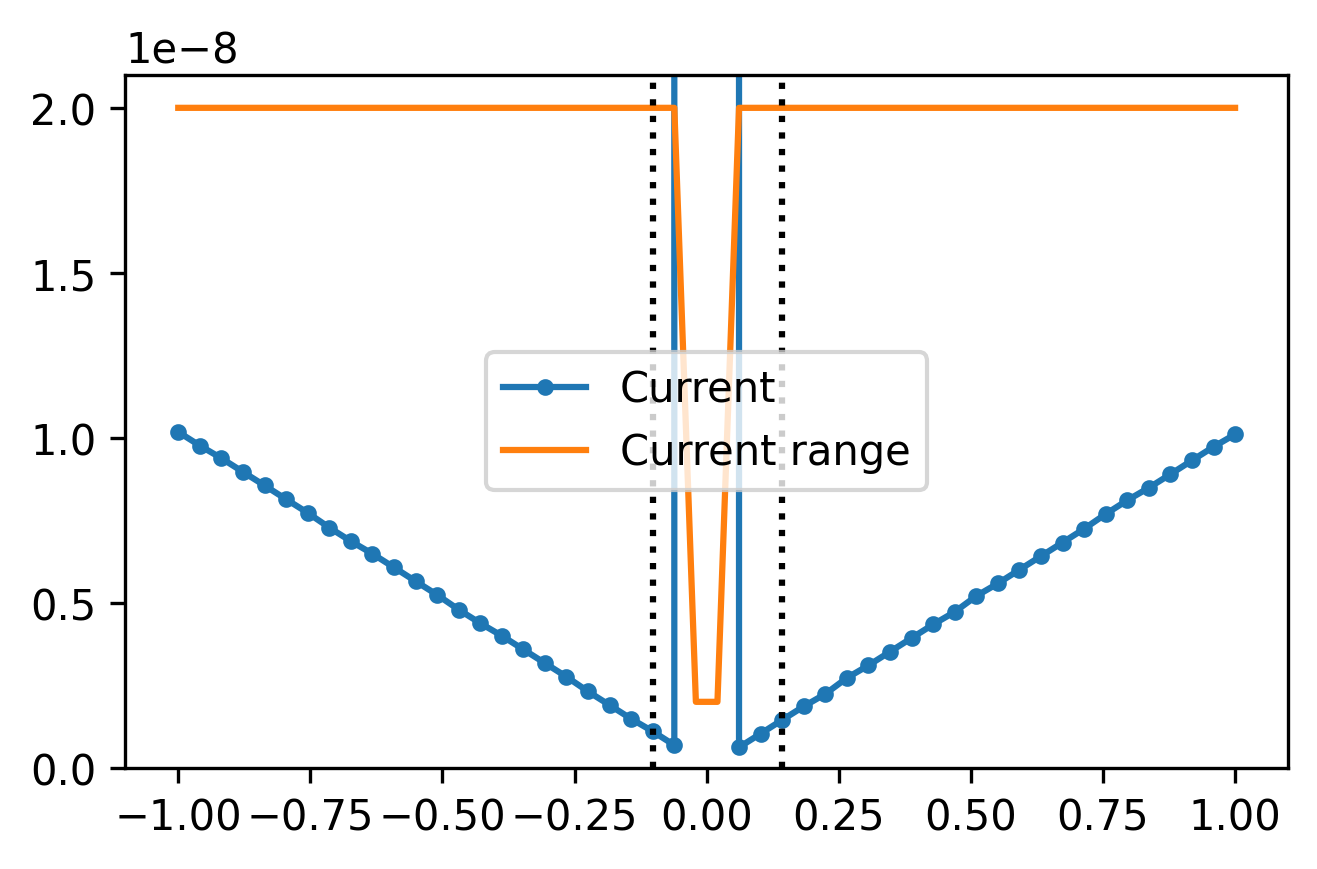

In [17]:
plt.figure(figsize=(5, 3), dpi=300)

plt.plot(V, abs(np.array([i[0] for i in r])), 'o-', label='Current', markersize=3)
plt.plot(V, [i[1] for i in r], label='Current range')
plt.vlines([-0.10204081632653073, 0.1428571428571428 ], ymin = 0, ymax=1e38, color='black', linestyles=':')
plt.ylim(0, 2.1e-8)
plt.legend();

In [25]:
len(r)

22

In [5]:
eval('2.0000000E-02\n')

0.02

: 

In [38]:
K.device.write(":SENS:CURR:NPLC 10")

20

In [17]:
K.device.write(':SOUR:VOLT:MCON 1;')
# K.device.read()

20

In [102]:
K.set_voltage_range(2)

Voltage range set to 2 V


In [11]:
K.set_voltage(0)
K.device.write('OUTP OFF;')

11

In [53]:
K.device.write(':SENS:RES:MAN:VSO:OPER ON;')

28

In [41]:
K.set_voltage(0)

In [40]:
while 1:
    K.set_voltage(0)
    # time.sleep(1e-3)
    K.set_voltage(1)
    # time.sleep(1e-3)

KeyboardInterrupt: 

In [90]:
K.device.write('MEAS:CURR?;')
K.device.read()

'+00.03107E-09NADC,08:34:48.00,09-Oct-2024,+02196RDNG#\n'

In [18]:

K.set_voltage(1)
K.device.write(':READ?;')
K.device.read()

'+0100.324E-09NADC,+0001631.117625secs,+02708RDNG#\n'

In [100]:
I = []
V = []
# keithley.source_voltage = 0
# keithley.enable_source()
# keithley.apply_voltage(voltage_range=5)
# keithley.measure_current(nplc=1, current=0.000105, auto_range=True)

for (v, i) in measure_IV(K, npoints=100):
    I.append(i)
    V.append(v)
    # print(i, v)

Voltage set to 0.5005 V and output enabled
Voltage set to 0.5005050505050505 V and output enabled
Voltage set to 0.500510101010101 V and output enabled
Voltage set to 0.5005151515151515 V and output enabled
Voltage set to 0.500520202020202 V and output enabled
Voltage set to 0.5005252525252525 V and output enabled
Voltage set to 0.500530303030303 V and output enabled
Voltage set to 0.5005353535353535 V and output enabled
Voltage set to 0.500540404040404 V and output enabled
Voltage set to 0.5005454545454545 V and output enabled
Voltage set to 0.500550505050505 V and output enabled
Voltage set to 0.5005555555555555 V and output enabled
Voltage set to 0.500560606060606 V and output enabled
Voltage set to 0.5005656565656565 V and output enabled
Voltage set to 0.500570707070707 V and output enabled


KeyboardInterrupt: 

In [19]:
I, V

([-3.78e-11,
  1.6824e-09,
  2.6877e-09,
  3.3639e-09,
  4.4153e-09,
  5.4408e-09,
  6.4656e-09,
  7.4951e-09,
  8.5321e-09,
  9.5453e-09,
  1.05625e-08,
  1.15878e-08,
  1.26278e-08,
  1.36337e-08,
  1.46672e-08,
  1.5696e-08,
  1.67143e-08,
  1.77196e-08,
  1.87564e-08,
  1.97677e-08,
  2.04601e-08,
  2.14786e-08,
  2.25018e-08,
  2.35385e-08,
  2.45332e-08,
  2.55718e-08,
  2.66205e-08,
  2.76335e-08,
  2.86568e-08,
  2.9685e-08,
  3.07021e-08,
  3.17564e-08,
  3.27513e-08,
  3.37831e-08,
  3.48186e-08,
  3.585e-08,
  3.6867e-08,
  3.79109e-08,
  3.85967e-08,
  3.96099e-08,
  4.0638e-08,
  4.16471e-08,
  4.26916e-08,
  4.36925e-08,
  4.47111e-08,
  4.57403e-08,
  4.67689e-08,
  4.78025e-08,
  4.88403e-08,
  4.985e-08,
  5.12174e-08,
  5.22579e-08,
  5.32803e-08,
  5.42957e-08,
  5.53136e-08,
  5.63606e-08,
  5.73673e-08,
  5.83954e-08,
  5.94173e-08,
  6.04365e-08,
  6.14492e-08,
  6.24757e-08,
  6.34941e-08,
  6.41786e-08,
  6.52068e-08,
  6.623e-08,
  6.726e-08,
  6.82843e-08,
  6

Text(0, 0.5, 'Current (A)')

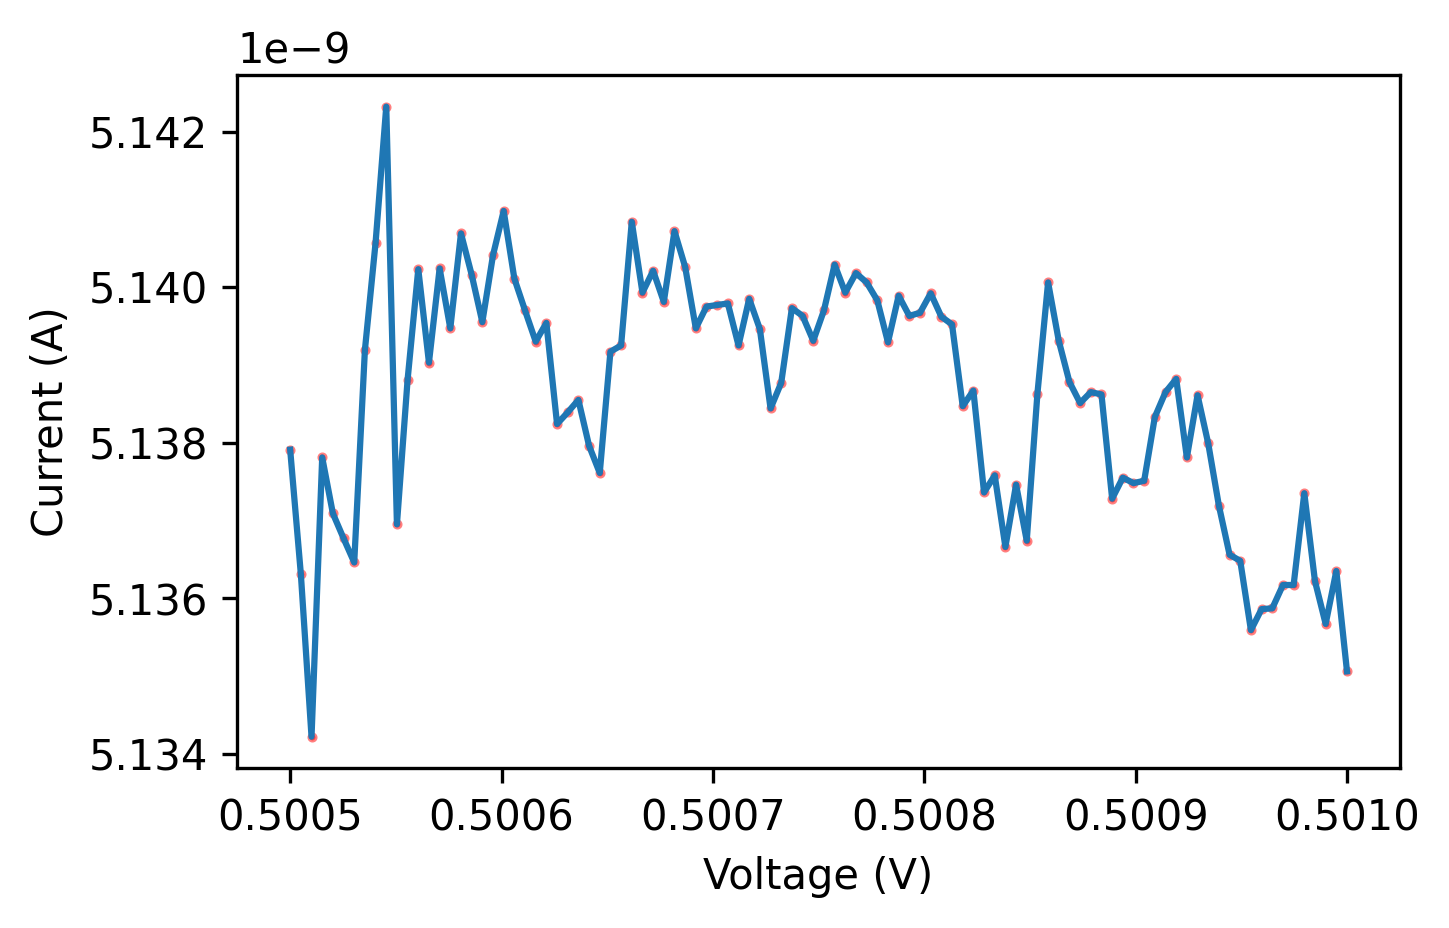

In [85]:
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(V, I)
plt.scatter(V, I, s=2, color='red', alpha=0.5)
plt.xlabel('Voltage (V)')
plt.ylabel('Current (A)')
# plt.show()

Text(0, 0.5, 'Resistance (R)')

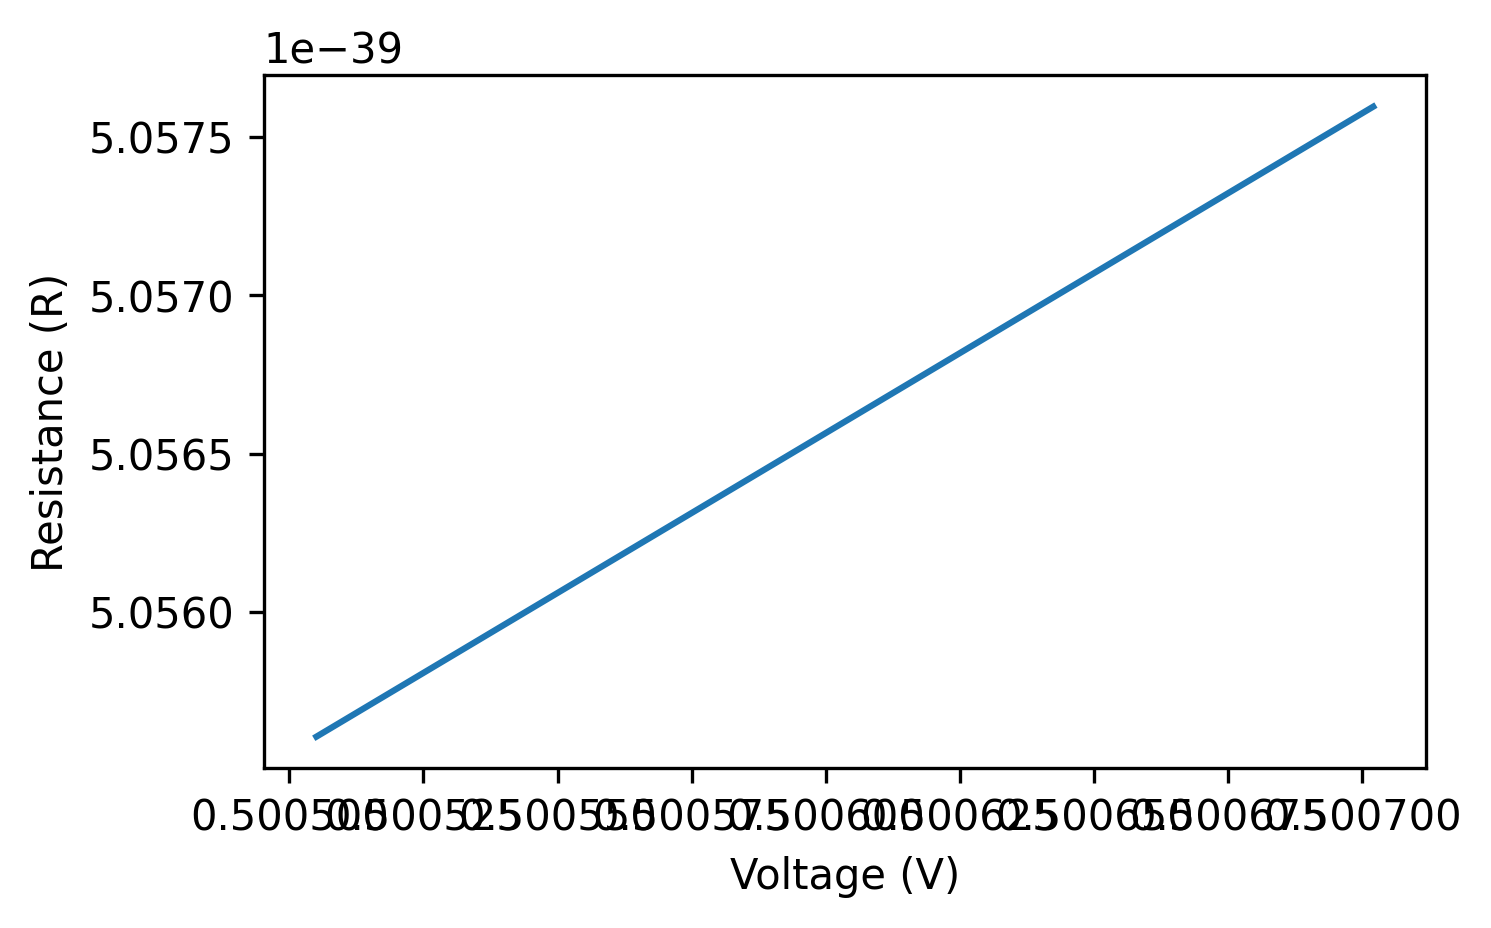

In [92]:
V = np.array(V)
plt.figure(figsize=(5, 3), dpi=300)
# plt.plot(V[10:], (V/I)[10:])
plt.plot(V[1:], (V/I)[1:])
plt.xlabel('Voltage (V)')
plt.ylabel('Resistance (R)')
# plt.show()

In [24]:
K.close()

Connection to Keithley 6517B closed.
